$$\Huge{\text{Proyecto Automatas Celulares}}$$

![Descripción de la imagen](https://drive.google.com/uc?export=view&id=1gEv2lt6vRFpZNOvln07r29k0Q65gJhtc)



# **Funciones**

In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
!pip install ipywidgets
import ipywidgets as widgets
from IPython.display import clear_output

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.2 MB/s eta 0:00:00


In [2]:
def asignarPosiciones(N, cantiPersona, matrix, valor):
  sigue = True
  while(sigue): # es necesario que no se remplacen los indices que ya tienen un valor asignado
    matrizCopia = matrix.copy()
    indices = np.random.choice(N*N, cantiPersona, replace=False) # Genera un vector de 1D de tamaño: cantidad de personas dado. Valores de 0 a N*N
    sigue = False
    for i in indices: # Recorre los valores del vector 'indice'
      if(matrix[i//N, i%N] == 0): # Se revisa si esa posición esta disponible
        matrizCopia[i//N, i%N] = valor
      else:
        sigue = True
  return matrizCopia

In [3]:
# Funición que genera una matriz basandose en los parámetros dados
def generarMatriz(cantidadPersonas, cantidadInfectados, cantidadInmunes, densidadEnRelacionAPersonas):
  N = (int)((cantidadPersonas*densidadEnRelacionAPersonas)**(1/2)) # Tamaño de la matriz basandose en los datos ingresados anteriormente
  cantiSucep = (cantidadPersonas - cantidadInfectados - cantidadInmunes) # El usuario pasa la cantidad deseada de perosnas, los suceptibles son dicha cantidad menos los infectados y los inmunes

  # Generar matriz de ceros de tamaño N*N para meter las personas
  matrix = np.zeros((N, N), dtype=object)

  matrix = asignarPosiciones(N, cantiSucep, matrix, 1) # Coloca la cantidad de suceptibles en la matriz en posiciones random.
  matrix = asignarPosiciones(N, cantidadInfectados, matrix, 2) # Coloca la cantidad de infectados en la matriz en posiciones random.
  matrix = asignarPosiciones(N, cantidadInmunes, matrix, 3) # Coloca la cantidad de inmunes en la matriz en posiciones random.

  return matrix

In [4]:
colors = {0: np.array([255, 255, 255]), # Muerto/Vacío (blanco)
          1: np.array([255, 153, 153]), # Suceptible (color piel)
          2: np.array([0, 255, 0]), # Infectado (verde)
          3: np.array([0, 0, 255]) # Inmune (Azul)
          }

# Función que toma la matriz de personas y le asigna colores para graficar
def asignarColoress(matrix):
  colored_matrix = np.zeros((matrix.shape[0], matrix.shape[1], 3), dtype=int)
  for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
      colored_matrix[i, j] = colors[matrix[i, j]]
  return colored_matrix

In [5]:
# Funcion para hacer mover una persona en hacia cualquier posición aledaña
def moverPersonas(matrix):
  for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
      if(matrix[i,j] == 1 or matrix[i,j] == 2 or matrix[i,j] == 3): # Mueve cualquiera de los 3
        mover = np.random.choice((-1,0,1), 2, replace=True)
        if(i + mover[0]>=0 and i + mover[0]<matrix.shape[0] and j + mover[1]>=0 and j + mover[1]<matrix.shape[1]):
          if(matrix[i + mover[0], j + mover[1]] == 0):
            matrix[i + mover[0], j + mover[1]] = matrix[i,j]
            matrix[i,j] = 0

In [6]:
# Función que permite infectar a los sanos de acuerdo a cierta probabilidad y si estan al lado de un infectado
def contagiar(matrix, probContagio):
  revisar = np.array([[-1,-1],[-1,0],[-1,1],[0,1],[1,1],[1,0],[1,-1],[0,-1]])
  for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
      if(matrix[i,j] == 2): # Infectado
        for k in revisar:
          if(i+k[0]>=0 and i+k[0]<matrix.shape[0] and j+k[1]>=0 and j+k[1]<matrix.shape[1]):
            if(matrix[i+k[0], j+k[1]] == 1): # Suceptible
              probabilidad = np.random.rand()
              if(probabilidad<probContagio):
                matrix[i+k[0], j+k[1]] = 2

In [7]:
muertes = np.array([], dtype=int)

# Función que permite matar a los infectados de acuerdo a cierta probabilidad
def mueren(matrix, probMuerte):
  global muertes
  matados = 0
  for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
      if(matrix[i,j] == 2): # Infectado
        probabilidad = np.random.rand()
        if(probabilidad<probMuerte):
          matrix[i,j] = 0
          matados += 1
  matados = matados + muertes[muertes.shape[0]-1]
  muertes = np.concatenate((muertes, np.array([matados])))

In [8]:
# Función que permite sanar a los infectados de acuerdo a cierta probabilidad
def sanar(matrix, probSanidad):
  for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
      if(matrix[i,j] == 2): # Infectado
        probabilidad = np.random.rand()
        if(probabilidad<probSanidad):
          matrix[i,j] = 3

In [9]:
extranjero = np.array([], dtype=int)

# Funcion que hace llegar personas del extranjero en los extremos de la matriz
def nacerExtremos(matrix, probNacer):
  global extranjero
  llegaron = 0
  for i in range(matrix.shape[0]):
    if(i==0 or i==matrix.shape[0]-1):
      for j in range(matrix.shape[1]):
        if(matrix[i,j] == 0): # Muerto
          probabilidad = np.random.rand()
          if(probabilidad<probNacer):
            matrix[i,j] = 1
            llegaron += 1
    else:
      if(matrix[i,0] == 0): # Muerto
        probabilidad = np.random.rand()
        if(probabilidad<probNacer):
          matrix[i,j] = 1
          llegaron += 1
      if(matrix[i,matrix.shape[1]-1] == 0): # Muerto
        probabilidad = np.random.rand()
        if(probabilidad<probNacer):
          matrix[i,j] = 1
          llegaron += 1
  llegaron = llegaron + extranjero[extranjero.shape[0]-1]
  extranjero = np.concatenate((extranjero, np.array([llegaron])))

In [10]:
suceptibles = np.array([], dtype=int)
infectados = np.array([], dtype=int)
inmunes = np.array([], dtype=int)

# Función que cuenta la cantidad de personas deacuerdo a su tipo en la matriz
def contarPersonas(matrix):
  global suceptibles, infectados, inmunes
  cantiSucepti = 0
  cantiInfecta = 0
  cantInmune = 0
  for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
      if(matrix[i,j] == 1):
        cantiSucepti += 1
      elif(matrix[i,j] == 2):
        cantiInfecta += 1
      elif(matrix[i,j] == 3):
        cantInmune += 1
  suceptibles = np.concatenate((suceptibles, np.array([cantiSucepti])))
  infectados = np.concatenate((infectados, np.array([cantiInfecta])))
  inmunes = np.concatenate((inmunes, np.array([cantInmune])))

In [11]:
def graficarCantidadPersonas(suceptibles, infectados, inmunes, muertes, extranjero):
  x = np.arange(len(suceptibles)) # Todos tienen la misma longitud dada en pasos
  plt.plot(x, suceptibles, label='Suceptibles', color='coral')
  plt.plot(x, infectados, label='Infectados', color='lime')
  plt.plot(x, inmunes, label='Inmunes', color='blue')
  plt.plot(x, muertes, label='Muertos', color='black')
  plt.plot(x, extranjero, label='Extranjeros', color='yellow')
  plt.plot(x, suceptibles+infectados+inmunes, label='Total Personas', color='red')
  plt.legend()
  plt.show()

In [16]:
def update(frame, img, matrix, probContagio, probMuerte, probSanidad, probNacer, ax):
    if frame == 0: # Si es el primer frame, no modifica la matriz para mostrar el estado inicial de creación
        img.set_array(asignarColoress(matrix))
    else:
        moverPersonas(matrix)
        contagiar(matrix, probContagio)
        mueren(matrix, probMuerte)
        sanar(matrix, probSanidad)
        nacerExtremos(matrix, probNacer)
        contarPersonas(matrix)
        img.set_array(asignarColoress(matrix))

    # Limpiar etiquetas anteriores
    for text in ax.texts:
        text.set_visible(False)
    # Agregar nueva etiqueta
    ax.text(0.02, 1.04, f'Frame: {frame+1} - Personas = {suceptibles[frame] + infectados[frame] + inmunes[frame]} - Muertos: {muertes[frame]} - Extranjeros: {extranjero[frame]}\nSuceptibles = {suceptibles[frame]} Infectados = {infectados[frame]} Inmunes = {inmunes[frame]}', transform=ax.transAxes, color='white', fontsize=9, bbox=dict(facecolor='black', alpha=0.8))
    return [img]

# **Main**

In [18]:
def main(cantidadPersonas, cantidadInfectados, cantidadInmunes, densidadEnRelacionAPersonas, probContagio, probMuerte, probSanidad, probNacer, pasos):
  # Limpiar la salida de la consola y mostrar los widgets iniciales
  clear_output()
  display(HTML("<style>.widget-label { min-width: 200px !important; }</style>"))
  display(cantiPersonas, cantiInfectados, cantiInmunes, densidad, probailidadContagio, probabilidadMuerte, probabilidadSanidad, probabilidadNacer, cantidadPasos, boton) # Mostrar nuevamente los botones

  # Evita que la cantidad de infectados y la cantidad de inmunes sea mayor a la catidad de personas
  if(cantidadInfectados>cantidadPersonas or cantidadInmunes>cantidadPersonas or cantidadInfectados+cantidadInmunes>cantidadPersonas):
    print(f'infectados o inmunes superan la catidad de personas')
  else:
    print(f'En proceso, espere...')
    global suceptibles, infectados, inmunes, muertes, extranjero # Definir que estas variables son globales

    # Se inician los arrays con la cantidad incial de personas
    suceptibles = np.array([cantidadPersonas-(cantidadInfectados+cantidadInmunes)], dtype=int)
    infectados = np.array([cantidadInfectados], dtype=int)
    inmunes = np.array([cantidadInmunes], dtype=int)
    muertes = np.array([0], dtype=int)
    extranjero = np.array([0], dtype=int)

    # Generar la matriz de personas
    matrix = generarMatriz(cantidadPersonas, cantidadInfectados, cantidadInmunes, densidadEnRelacionAPersonas)

    # Crear la figura y el objeto de imagen
    fig, ax = plt.subplots()
    img = ax.imshow(asignarColoress(matrix), animated=True)
    # Crear la animación
    ani = animation.FuncAnimation(fig, update, frames=range(pasos), fargs=(img, matrix, probContagio, probMuerte, probSanidad, probNacer, ax), interval=100, blit=True, repeat=False)
    # Mostrar la animación en Google Colab
    display(HTML(ani.to_jshtml()))
    plt.close()

    # Graficar la evolición de las personas desde en todos los pasos
    print(f"\n")
    graficarCantidadPersonas(suceptibles, infectados, inmunes, muertes, extranjero)

In [24]:
# Crear widgets para ingresar valores
cantidadPasos = widgets.BoundedIntText(value=200, min=1, max=10000, description='Pasos:')
cantiPersonas = widgets.BoundedIntText(value=500, min=1, max=10000, description='Personas Totales:')
cantiInfectados = widgets.BoundedIntText(value=1, min=0, max=10000, description='Infectados:')
cantiInmunes = widgets.BoundedIntText(value=1, min=0, max=10000, description='Inmunes:')
densidad = widgets.BoundedIntText(value=8, min=2, max=100, description='Densidad:')
probailidadContagio = widgets.BoundedFloatText(value=0.8, min=0, max=1, step=0.001, description='Probabilidad de Contagio:')
probabilidadMuerte = widgets.BoundedFloatText(value=0.008, min=0, max=1, step=0.001, description='Probabilidad de Muerte:')
probabilidadSanidad = widgets.BoundedFloatText(value=0.01, min=0, max=1, step=0.001, description='Probabilidad de Sanidad:')
probabilidadNacer = widgets.BoundedFloatText(value=0.005, min=0, max=1, step=0.001, description='Probabilidad de Nacimiento:')

# Crear un botón para ejecutar la función
boton = widgets.Button(description='Simular')
boton.on_click(lambda b: main(cantiPersonas.value, cantiInfectados.value, cantiInmunes.value, densidad.value, probailidadContagio.value, probabilidadMuerte.value, probabilidadSanidad.value, probabilidadNacer.value, cantidadPasos.value))

In [20]:
def simular():
  # Mostrar los widgets
  display(HTML("<style>.widget-label { min-width: 200px !important; }</style>"))
  display(cantiPersonas, cantiInfectados, cantiInmunes, densidad, probailidadContagio, probabilidadMuerte, probabilidadSanidad, probabilidadNacer, cantidadPasos, boton)

# **Simulador**

BoundedIntText(value=700, description='Personas Totales:', max=10000, min=1)

BoundedIntText(value=1, description='Infectados:', max=10000)

BoundedIntText(value=1, description='Inmunes:', max=10000)

BoundedIntText(value=8, description='Densidad:', min=2)

BoundedFloatText(value=0.8, description='Probabilidad de Contagio:', max=1.0, step=0.001)

BoundedFloatText(value=0.008, description='Probabilidad de Muerte:', max=1.0, step=0.001)

BoundedFloatText(value=0.01, description='Probabilidad de Sanidad:', max=1.0, step=0.001)

BoundedFloatText(value=0.008, description='Probabilidad de Nacimiento:', max=1.0, step=0.001)

BoundedIntText(value=250, description='Pasos:', max=10000, min=1)

Button(description='Simular', style=ButtonStyle())

En proceso, espere...


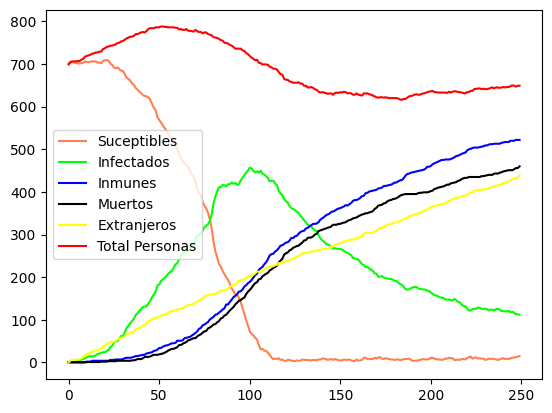

In [23]:
simular()